<a href="https://colab.research.google.com/github/nishant-pitta/Dysarthria-Detection/blob/main/TestedDysarthriaProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import files
files.upload()

! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list

!kaggle datasets download iamhungundji/dysarthria-detection

!rm -rf torgo_data
!rm -rf input-data/dysarthria-detection

!mkdir -p input-data/dysarthria-detection

!mv dysarthria-detection.zip input-data/dysarthria-detection

!unzip -qq input-data/dysarthria-detection/dysarthria-detection.zip -d input-data/dysarthria-detection

!cd 

!pwd

# !pip install sound conversion package
!pip install soundfile
!pip install ffmpeg
!pip install --upgrade AudioConverter

#install noisereduce package
!pip install noisereduce

#install tensorflow
!pip install tensorflow


!rm -rf nishant-test-dir
!mkdir nishant-test-dir

#create directories to filter noise from the original files and store in fileterd directory
!mkdir /content/input-data/dysarthria-detection/filtered_torgo_data
!mkdir /content/input-data/dysarthria-detection/filtered_torgo_data/dysarthria_female
!mkdir /content/input-data/dysarthria-detection/filtered_torgo_data/dysarthria_male
!mkdir /content/input-data/dysarthria-detection/filtered_torgo_data/non_dysarthria_female
!mkdir /content/input-data/dysarthria-detection/filtered_torgo_data/non_dysarthria_male
!mkdir /content/nishant-saved-model
!mkdir /content/nishant-saved-model/assets
!mkdir /content/nishant-saved-model/variables

!ls /content/input-data/dysarthria-detection

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.preprocessing import minmax_scale
import IPython.display as ipd

from tqdm import tqdm
from scipy.io import wavfile
import noisereduce as nr
import soundfile as sf

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

Saving kaggle.json to kaggle.json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                        title                                        size  lastUpdated          downloadCount  voteCount  usabilityRating  
---------------------------------------------------------  ------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
themrityunjaypathak/covid-cases-and-deaths-worldwide       Covid Cases and Deaths WorldWide              8KB  2023-02-01 12:22:51          10055        333  1.0              
datascientistanna/customers-dataset                        Shop Customer Data                           23KB  2023-02-07 18:42:21           8497        203  1.0              
justin2028/unemployment-in-america-per-us-state            Unemployment in America, Per US State       826KB  2023-03-02 07:26:03            779         43  1.0              
anas123siddiqui/mobiles        

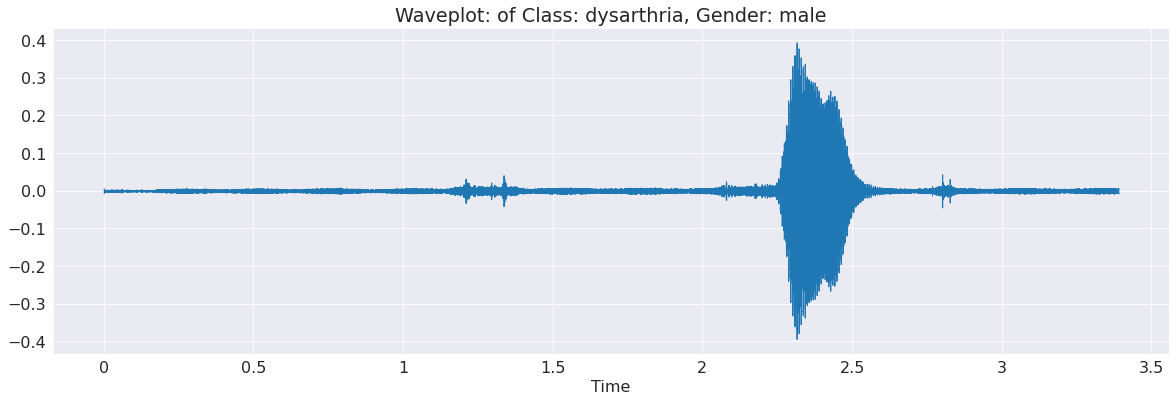

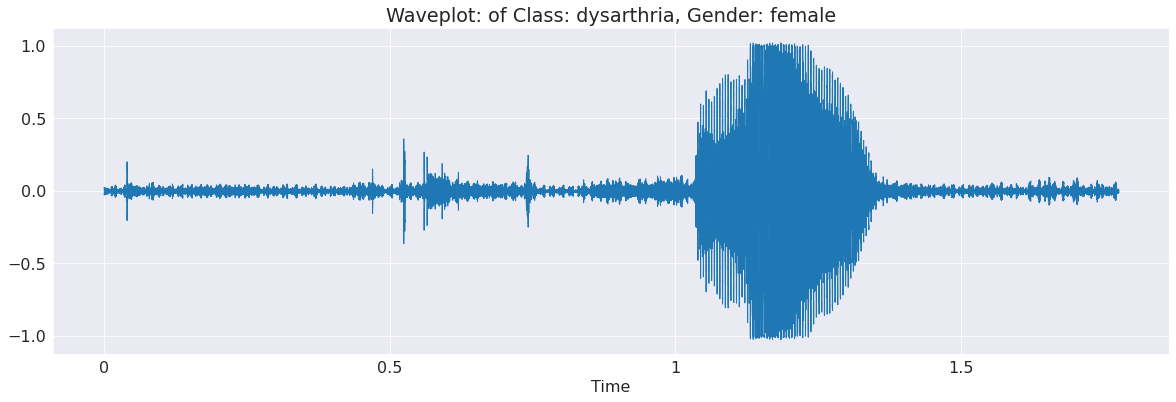

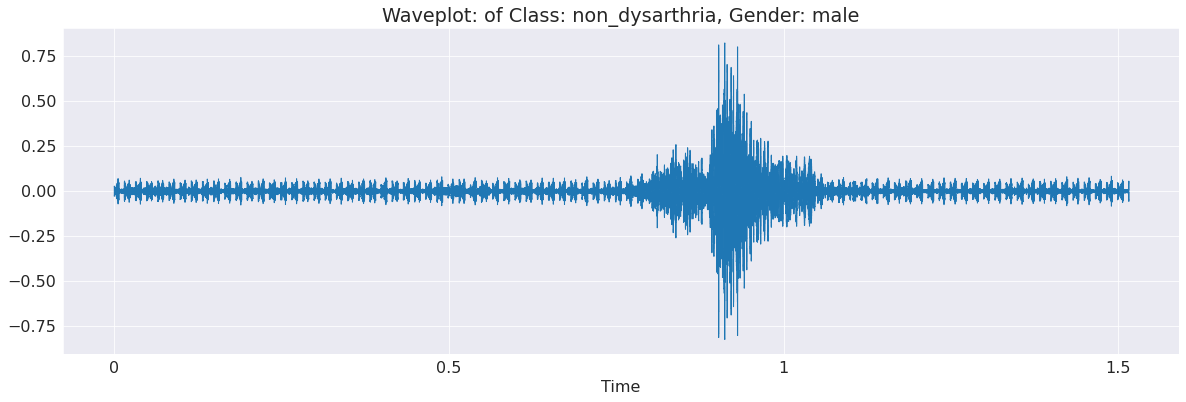

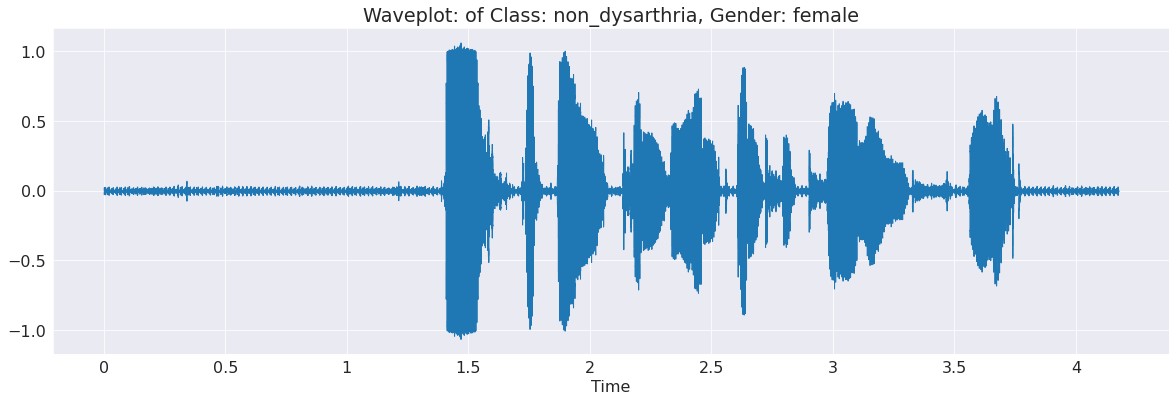

In [ ]:
# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# import os
# import re
# import warnings
# import matplotlib.pyplot as plt
# import seaborn as sns
# import librosa
# import librosa.display
# from sklearn.preprocessing import minmax_scale
# import IPython.display as ipd

plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

directory = '/content/input-data/dysarthria-detection'
data = pd.read_csv("/content/input-data/dysarthria-detection/torgo_data/data.csv")
data['filename'] = data['filename'].apply(lambda x: os.path.join(directory,x))
data

def show_waveplot(audio_path,label,gender):
    x , sr = librosa.load(audio_path)
    plt.figure(figsize=(20, 6))
    librosa.display.waveshow(x, sr=sr)
    plt.title(f"Waveplot: of Class: {label}, Gender: {gender}")

def show_spectrogram(audio_path,label,gender):
    x , sr = librosa.load(audio_path)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(20,6))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz',cmap='plasma')
    plt.colorbar()
    plt.title(f"Spectrogram of Class: {label}, Gender: {gender}")
    
def show_zcr(audio_path,label,gender):
    x , sr = librosa.load(audio_path)
    zero_crossings = librosa.zero_crossings(x)
    print("Sum of zero crossing ", zero_crossings.sum())
    plt.figure(figsize=(20, 5))
    plt.title(f'Zero Crossing Rate of Class: {label}, Gender: {gender}')
    zcrs = librosa.feature.zero_crossing_rate(x)
    plt.plot(zcrs[0])
    plt.show()
    
def normalize(x, axis=0):
    return minmax_scale(x, axis=axis)

def show_spectral_centroids(audio_path,label,gender):
    plt.figure(figsize=(20, 5))
    plt.title(f'Spectral Centroids of Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    spectral_centroids = librosa.feature.spectral_centroid(x, sr=sr)[0]
    frames = range(len(spectral_centroids))
    t = librosa.frames_to_time(frames)
    librosa.display.waveshow(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_centroids), color='r')
    plt.show()
    
def show_spectral_rolloff(audio_path,label,gender):
    plt.figure(figsize=(20, 5))
    plt.title(f'Spectral Rolloff of Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    spectral_rolloff = librosa.feature.spectral_rolloff(x, sr=sr, roll_percent=0.01)[0]
    frames = range(len(spectral_rolloff))
    t = librosa.frames_to_time(frames)
    librosa.display.waveshow(x, sr=sr, alpha=0.4)
    plt.plot(t, normalize(spectral_rolloff), color='r')
    plt.show()
    
def show_mfccs(audio_path,label,gender):
    plt.figure(figsize=(20, 6))
    plt.title(f'MFCC of Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    mfccs = librosa.feature.mfcc(y=x, sr=sr)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time',cmap='plasma')
    plt.show()
    
def show_melspectro(audio_path,label,gender):
    plt.figure(figsize=(20, 6))
    plt.title(f'Mel Spectro of Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    melspectro = librosa.feature.melspectrogram(y=x, sr=sr)
    librosa.display.specshow(melspectro, sr=sr, x_axis='time',cmap='plasma')
    plt.show()  

    data.sample(frac=1).reset_index(drop=True,inplace=True)
  
male_dysarthric = data[(data['gender']=='male') & (data['is_dysarthria']=='dysarthria')].sample(1)
female_dysarthric = data[(data['gender']=='female') & (data['is_dysarthria']=='dysarthria')].sample(1)
male_ndysarthric = data[(data['gender']=='male') & (data['is_dysarthria']=='non_dysarthria')].sample(1)
female_ndysarthric = data[(data['gender']=='female') & (data['is_dysarthria']=='non_dysarthria')].sample(1)


show_waveplot(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_waveplot(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
show_waveplot(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
show_waveplot(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)


# show_spectrogram(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
# show_spectrogram(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
# show_spectrogram(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
# show_spectrogram(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)


# show_zcr(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
# show_zcr(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
# show_zcr(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
# show_zcr(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)


# show_spectral_centroids(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
# show_spectral_centroids(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
# show_spectral_centroids(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
# show_spectral_centroids(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)


# show_spectral_rolloff(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
# show_spectral_rolloff(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
# show_spectral_rolloff(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
# show_spectral_rolloff(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)


# show_mfccs(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
# show_mfccs(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
# show_mfccs(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
# show_mfccs(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)


# show_melspectro(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
# show_melspectro(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
# show_melspectro(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
# show_melspectro(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)

    

In [ ]:
#filtering white noise from orig torgo dataset
#putting filtered data in filtered_torgo_data dir
# from tqdm import tqdm
# from scipy.io import wavfile
# import noisereduce as nr
# import soundfile as sf

print(type(data))

count = 0
for i, record in tqdm(data.iterrows(), total=data.shape[0]):
    try:
        # loading file
        rate, x = wavfile.read(record['filename'])
        reduced_noise = nr.reduce_noise(y=x, sr=rate)

        new_filename = record['filename'].replace('torgo_data', 'filtered_torgo_data')

        # print('\n')
        # print (new_filename)
        # break
        wavfile.write(new_filename, rate, reduced_noise)
        # sf.write(record['filename'], data, rate)
    except EOFError:
        pass
    except:
      
      count += 1
      pass

# calling function
# reduce_noise(data)
print(count)


<class 'pandas.core.frame.DataFrame'>


100%|██████████| 2000/2000 [01:38<00:00, 20.40it/s]

1


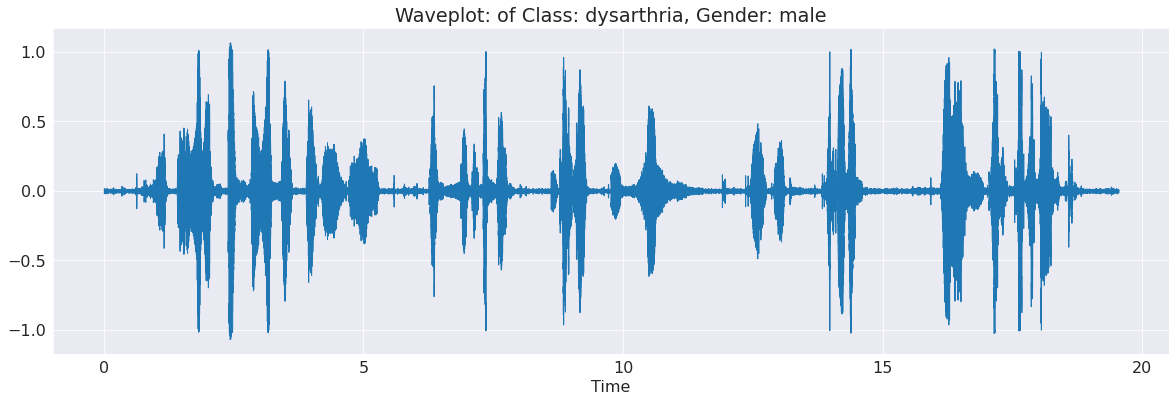

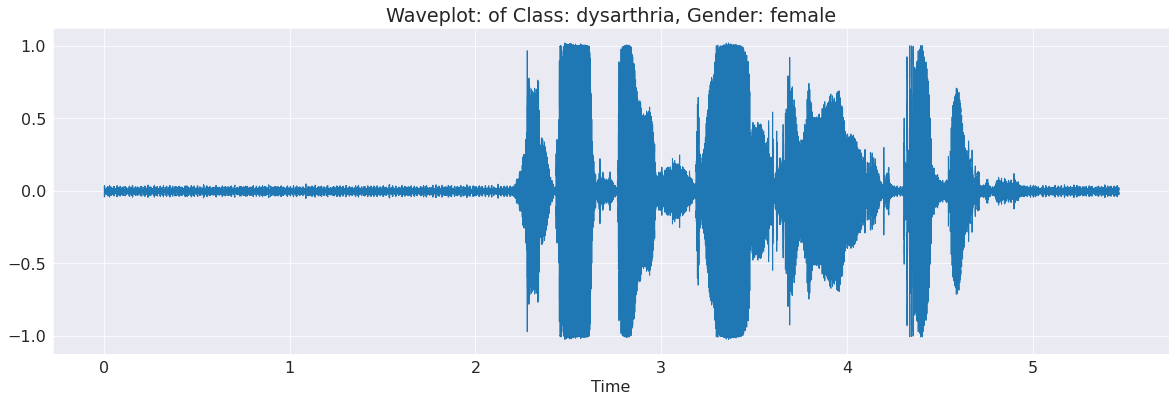

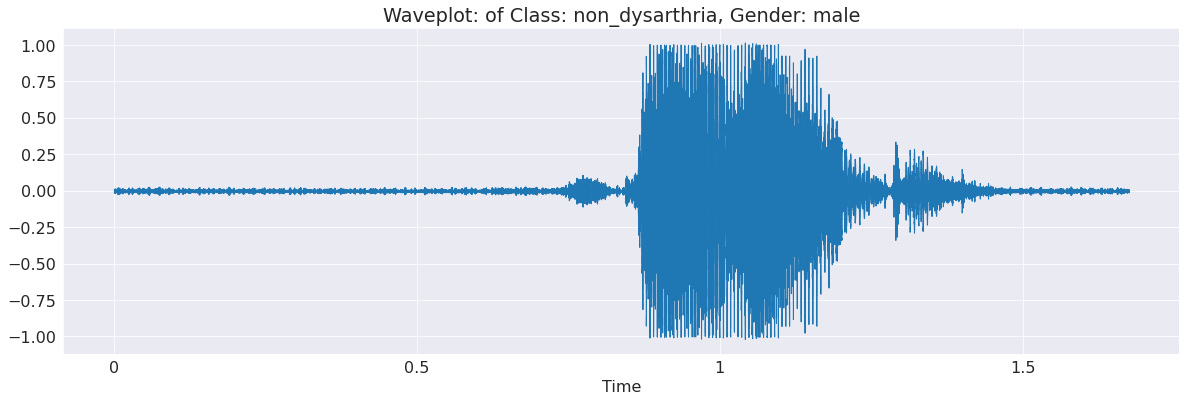

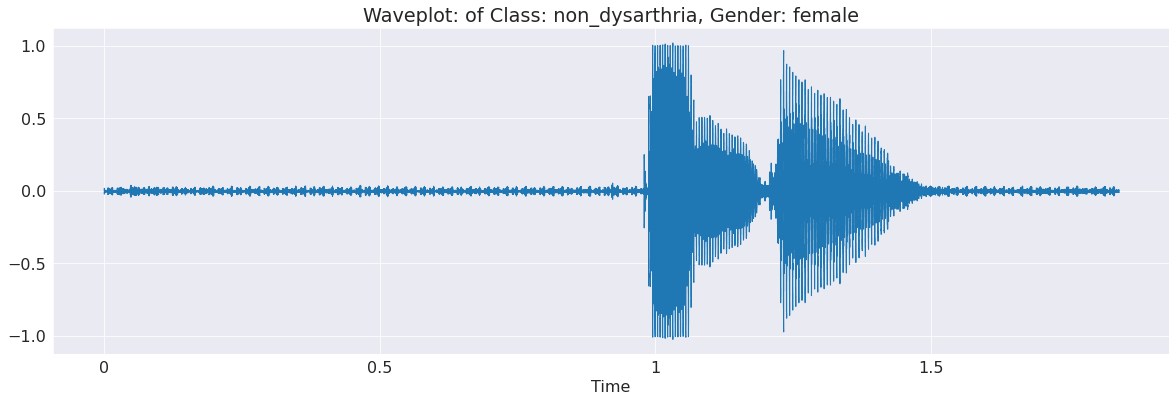

In [ ]:
# showing the graphs for the filtered data
plt.rcParams['figure.figsize'] = (20,8)
plt.rcParams['font.size'] = 16
sns.set_style('darkgrid')
warnings.filterwarnings("ignore")

directory = '/content/input-data/dysarthria-detection'
data = pd.read_csv("/content/input-data/dysarthria-detection/filtered_torgo_data/data.csv")
data['filename'] = data['filename'].apply(lambda x: os.path.join(directory,x))
data


data.sample(frac=1).reset_index(drop=True,inplace=True)
  
male_dysarthric = data[(data['gender']=='male') & (data['is_dysarthria']=='dysarthria')].sample(1)
female_dysarthric = data[(data['gender']=='female') & (data['is_dysarthria']=='dysarthria')].sample(1)
male_ndysarthric = data[(data['gender']=='male') & (data['is_dysarthria']=='non_dysarthria')].sample(1)
female_ndysarthric = data[(data['gender']=='female') & (data['is_dysarthria']=='non_dysarthria')].sample(1)


show_waveplot(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_waveplot(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
show_waveplot(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
show_waveplot(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)


# show_spectrogram(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
# show_spectrogram(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
# show_spectrogram(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
# show_spectrogram(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)


# show_zcr(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
# show_zcr(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
# show_zcr(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
# show_zcr(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)


# show_spectral_centroids(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
# show_spectral_centroids(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
# show_spectral_centroids(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
# show_spectral_centroids(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)


# show_spectral_rolloff(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
# show_spectral_rolloff(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
# show_spectral_rolloff(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
# show_spectral_rolloff(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)


# show_mfccs(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
# show_mfccs(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
# show_mfccs(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
# show_mfccs(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)


# show_melspectro(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
# show_melspectro(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)
# show_melspectro(male_ndysarthric.iloc[0].filename, male_ndysarthric.iloc[0].is_dysarthria, male_ndysarthric.iloc[0].gender)
# show_melspectro(female_ndysarthric.iloc[0].filename, female_ndysarthric.iloc[0].is_dysarthria, female_ndysarthric.iloc[0].gender)


In [ ]:
#copying (index file) data.csv to filtered data dir
!cp /content/input-data/dysarthria-detection/torgo_data/data.csv /content/input-data/dysarthria-detection/filtered_torgo_data/data.csv

#modifying iondex file to make sure files are pointing to the rigth dir
directory = '/content/input-data/dysarthria-detection'
data = pd.read_csv("/content/input-data/dysarthria-detection/torgo_data/data.csv")
data['filename'] = data['filename'].apply(lambda x: os.path.join(directory,x))
data['filename'] = data['filename'].str.replace('torgo_data', 'filtered_torgo_data')
data

,is_dysarthria,gender,filename
0,non_dysarthria,female,/content/input-data/dysarthria-detection/filte...
1,non_dysarthria,female,/content/input-data/dysarthria-detection/filte...
2,non_dysarthria,female,/content/input-data/dysarthria-detection/filte...
3,non_dysarthria,female,/content/input-data/dysarthria-detection/filte...
4,non_dysarthria,female,/content/input-data/dysarthria-detection/filte...
...,...,...,...
1995,dysarthria,male,/content/input-data/dysarthria-detection/filte...
1996,dysarthria,male,/content/input-data/dysarthria-detection/filte...
1997,dysarthria,male,/content/input-data/dysarthria-detection/filte...
1998,dysarthria,male,/content/input-data/dysarthria-detection/filte...


In [ ]:
#extracting features from the dataset

#Feature Extraction aims to reduce the number of features in a dataset by creating new features from the existing ones 
#HTK vs Slaney -  HTK formula is widely used in many speech recognition applications, as it has been shown to be effective in many real-world scenarios.
# from tqdm import tqdm
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score

def feature_extraction(df):
    features = []
    for i,record in tqdm(df.iterrows(),total=df.shape[0]):
        try:
            x , sr = librosa.load(record['filename'])
            mean_mfcc = np.mean(librosa.feature.mfcc(y=x, sr=sr, n_mfcc=128, htk=True),axis=1)  #(Array containing numbers whose mean is desired, axes along which the means are computed)
                                                                                #librose.feature.mfcc(audio time series, sampling rate of y (x), number of MFCCs to return, use HTK formula instead of Slaney)
            #print(mean_mfcc)
            features.append(mean_mfcc)
        except EOFError:
            pass
        except:
            pass      
        
    dataf = pd.DataFrame(features)
    dataf['class'] = df['is_dysarthria']
    #print(features)
    return dataf

dataf = feature_extraction(data)

dataf

dataf.loc[dataf['class']=='non_dysarthria','class'] = 0.0
dataf.loc[dataf['class']=='dysarthria','class'] = 1.0
dataf['class'] = dataf['class'].astype(float)

X = dataf.iloc[:,:-1].values
y = dataf.iloc[:,-1]

X.shape, y.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)  #(input array that contains the feature data, contains the vector of target values, number will represent the proportion of observations that will be in the test set(200), returns training and test subsets that have the same proportions of class labels as the input dataset)
X_train = X_train.reshape(-1,16,8,1)
X_test = X_test.reshape(-1,16,8,1)



100%|██████████| 2000/2000 [04:31<00:00,  7.35it/s]


In [ ]:
X = dataf.iloc[:,:-1].values
y = dataf.iloc[:,-1]

X.shape, y.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)  #(input array that contains the feature data, contains the vector of target values, number will represent the proportion of observations that will be in the test set(200), returns training and test subsets that have the same proportions of class labels as the input dataset)
X_train = X_train.reshape(-1,16,8,1)
X_test = X_test.reshape(-1,16,8,1)

In [ ]:
X.shape

(1999, 128)

In [ ]:
#training the model with the extracted features
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#output filters - passes all frequencies equally well
#2-D convolutional layer applies sliding convolutional filters to 2-D input
#pool layers- used to reduce the dimensions of the feature maps.
#verbose=1 - progress bar (to see how you want to view output)
#Dense layer - feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer

model = Sequential([
    InputLayer(input_shape=(16, 8, 1)),                                           #(shape, batch size)
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = "same"),  #(number of output filters, height and width, Activation function, padding with zeros evenly)
    MaxPooling2D(2, 2),                                                           #(pool_Size, Strides - Specifies how far the pooling window moves for each pooling step)
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = "same"),  #""
    MaxPooling2D(2, 2),                                                           #""
    Flatten(),                                                                    #convert multi-dimensional arrays into a 1-D array
    Dense(32, activation='relu'),                                                 #(dimensionality of the output space, Activation function)
    Dense(1, activation='sigmoid')                                                #""
])
model.summary()


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy']) #(optimizer='adam' is a gradient descent method, type of Loss function,)


model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)                #(NAME, metric name to monitor, If save_best_only=True, the decision to overwrite the current save file is made based on either the maximization or the minimization of the monitored quantity,
                                                      #only saves when the model is considered the "best" and the latest best model according to the quantity monitored will not be overwritten
                                                      #, verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True) #(quantity to be modeled, Minimum change in the monitored quantity to qualify as an improvement, Number of epochs with no improvement after which training will be stopped, verbose=1, restore model weights from the epoch with the best value of the monitored quantity)

history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test,y_test), callbacks=[checkpoint,earlystopping]) #(input data, target data, iterations to be trained, Data on which to evaluate the loss, List of callbacks to apply during training)

model.save('nishant-dysarthria-trained-model')

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 16, 8, 32)         320       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 8, 4, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 8, 4, 64)          18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 4, 2, 64)         0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 32)              

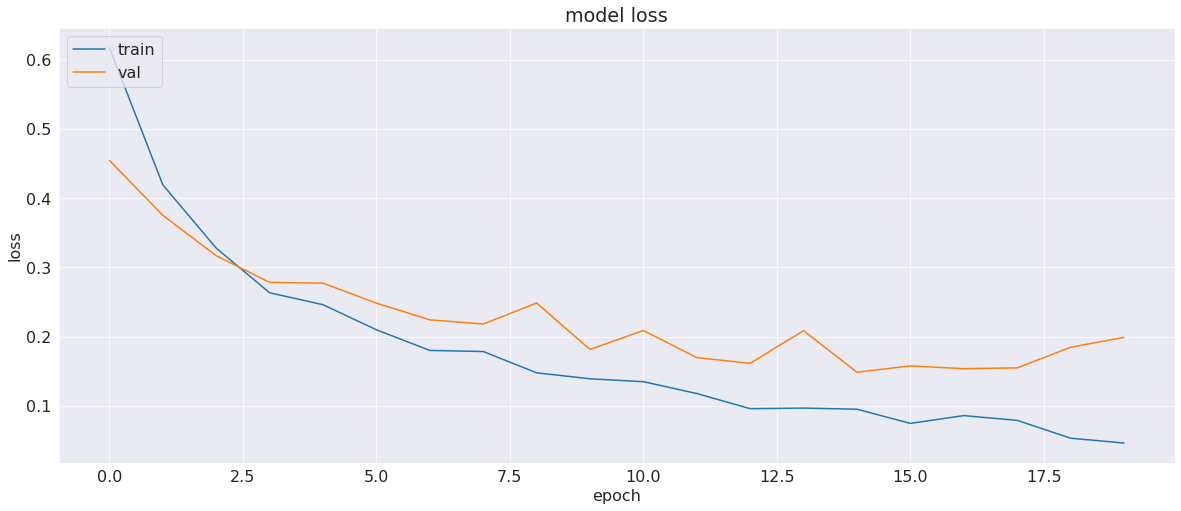

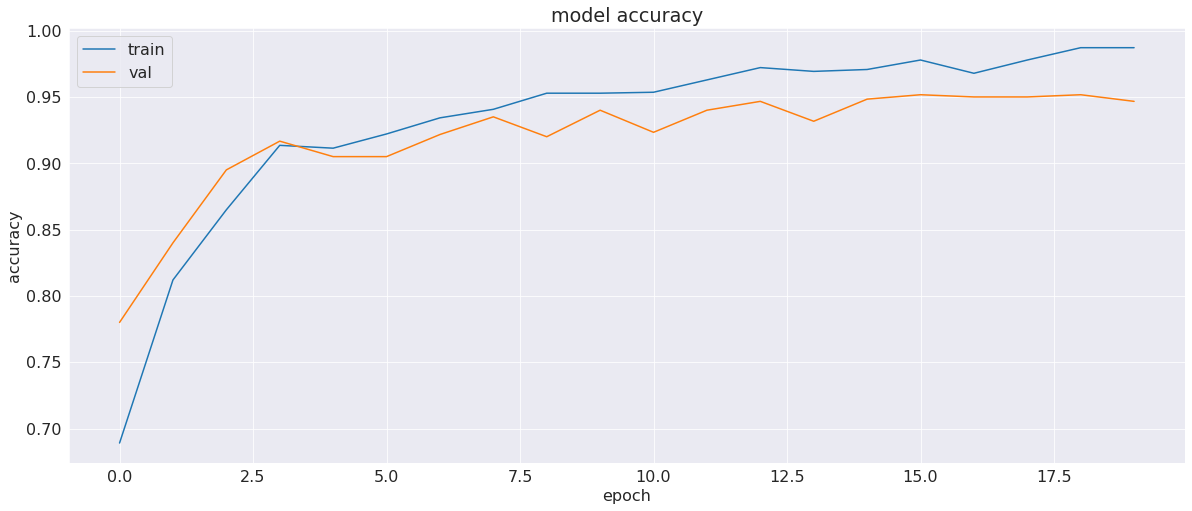

19/19 [==============================] - 0s 5ms/step


In [ ]:
#model summary
#learning curves
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

y_pred = model.predict(X_test)

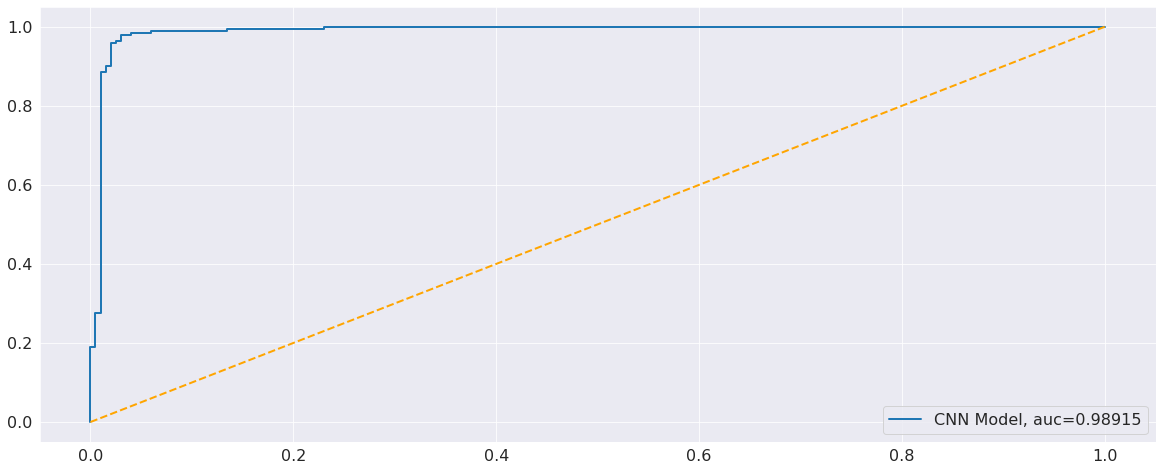

In [ ]:
#ROC Curve and AUC Score

plt.figure(figsize=(20,8))
fpr, tpr, _ = roc_curve(y_test,  y_pred)
auc = roc_auc_score(y_test, y_pred)
plt.plot(fpr,tpr,label="CNN Model, auc="+str(auc),lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.legend(loc=4)
plt.show()

y_pred[y_pred>=0.5] = 1
y_pred[y_pred<0.5] = 0

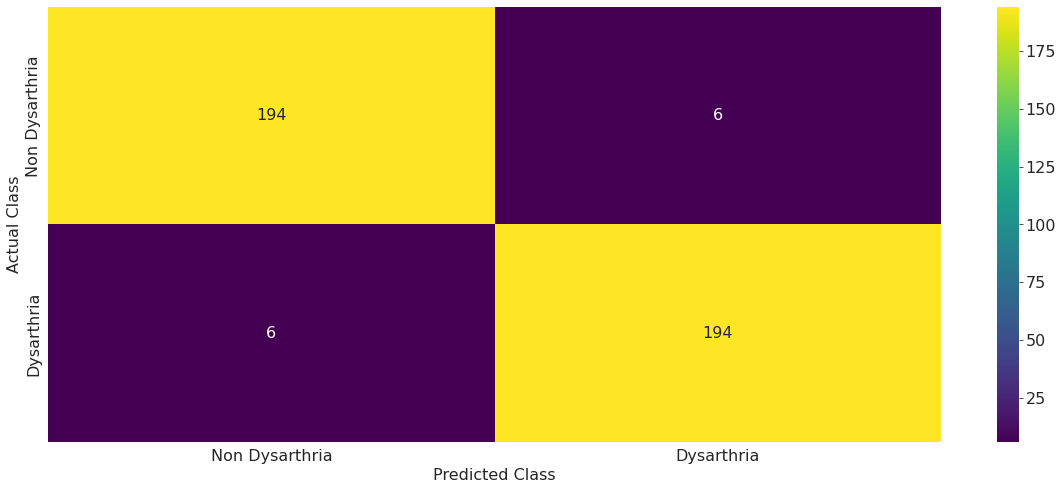

In [ ]:
#Confusion Matrix

sns.heatmap(confusion_matrix(y_test, y_pred),cmap='viridis',annot=True,fmt='.3g',
            xticklabels=['Non Dysarthria','Dysarthria'],yticklabels=['Non Dysarthria','Dysarthria'])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [ ]:
#Classification Report

print(classification_report(y_test,y_pred))

print("Recall Score of the Model: ",recall_score(y_test,y_pred))


              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97       200
         1.0       0.97      0.97      0.97       200

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400

Recall Score of the Model:  0.97


In [ ]:
#imports working demo-ready model from drive
from google.colab import drive
drive.mount('/content/drive')
%cd drive
%cd MyDrive
%cd 01_Files
#!unzip Trained_Model_01.zip

!cp /content/drive/MyDrive/Demo_Files/working_files.zip /content/nishant-test-dir/.
%cd /content/nishant-test-dir
!unzip working_files.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive'
/content/nishant-test-dir
[Errno 2] No such file or directory: 'MyDrive'
/content/nishant-test-dir
[Errno 2] No such file or directory: '01_Files'
/content/nishant-test-dir
/content/nishant-test-dir
Archive:  working_files.zip
replace __MACOSX/._working_files? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:


nishant_trained_model = tf.keras.models.load_model('/content/drive/MyDrive/01_Files/Trained_Model_01')
#nishant_trained_model = model

# Check its architecture
nishant_trained_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 16, 8, 32)         320       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 8, 4, 32)         0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 8, 4, 64)          18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 4, 2, 64)         0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 512)               0         
                                                                 
 dense_24 (Dense)            (None, 32)              

In [ ]:
#Test wave files directly without noise TEST HERE
file_name = "withM1";

wav_filename = f"/content/nishant-test-dir/working_files/{file_name}.wav"
print(wav_filename)

#remove the noise from the wav file
no_noise_wav_filename = f"/content/nishant-test-dir/working_files/no-noise-{file_name}.wav"
print(no_noise_wav_filename)

#remove the noise from the wav file
rate, x = wavfile.read(wav_filename)
reduced_noise = nr.reduce_noise(y=x, sr=rate)
wavfile.write(no_noise_wav_filename, rate, reduced_noise)
print('remove noise from the file')

# Evaluate the restored model
# Load the audio file and extract features
x , sr = librosa.load(no_noise_wav_filename)
X_online = np.mean(librosa.feature.mfcc(y=x, sr=sr, n_mfcc=128),axis=1)

X_online = X_online.reshape(-1,16,8,1)

# Generate a prediction on the audio data
# prediction = nishant_trained_model.predict(X_online)
prediction = nishant_trained_model.predict(X_online)

# printing prediction
# Get the probability of the dysarthria class
dysarthria_prob = prediction[0][0]
print('prediction:', dysarthria_prob)

# Set a threshold for determining whether the person has dysarthria
threshold = 0.5

if dysarthria_prob > threshold:
    print('The person is likely to have dysarthria.')
else:
    print('The person is likely to be healthy.')

ipd.Audio(no_noise_wav_filename)

#show_waveplot(wav_filename, "dysarthria", "male")


/content/nishant-test-dir/working_files/withM1.wav
/content/nishant-test-dir/working_files/no-noise-withM1.wav
remove noise from the file


<ipython-input-18-93c525ae1d23>:12: WavFileWarning: Reached EOF prematurely; finished at 253324 bytes, expected 253332 bytes from header.
  rate, x = wavfile.read(wav_filename)


1/1 [==============================] - 0s 32ms/step
prediction: 0.9219205
The person is likely to have dysarthria.


In [ ]:
# Convert ma4a files to .wav file and without noise TEST HERE
file_name = "nishT1";

m4a_file = f'/content/nishant-test-dir/working_files/{file_name}.m4a'
wav_filename = f"/content/nishant-test-dir/working_files/{file_name}.wav"

print(m4a_file)
print(wav_filename)

#convert m4a file to wav file.
from pydub import AudioSegment
track = AudioSegment.from_file(m4a_file,  format= 'm4a')
file_handle = track.export(wav_filename, format='wav')

#remove the noise from the wav file
no_noise_wav_filename = f"/content/nishant-test-dir/working_files/no-noise-{file_name}.wav"
print(no_noise_wav_filename)

rate, x = wavfile.read(wav_filename)
reduced_noise = nr.reduce_noise(y=x, sr=rate)
wavfile.write(no_noise_wav_filename, rate, reduced_noise)
print('remove noise from the file')

# Evaluate the restored model
# Load the audio file and extract features
x , sr = librosa.load(no_noise_wav_filename)
X_online = np.mean(librosa.feature.mfcc(y=x, sr=sr, n_mfcc=128),axis=1)

X_online = X_online.reshape(-1,16,8,1)

# Generate a prediction on the audio data
prediction = nishant_trained_model.predict(X_online)

# printing prediction
# Get the probability of the dysarthria class
dysarthria_prob = prediction[0][0]
print('prediction:', dysarthria_prob)

# Set a threshold for determining whether the person has dysarthria
threshold = 0.5

if dysarthria_prob > threshold:
    print('The person is likely to have dysarthria.')
else:
    print('The person is likely to be healthy.')

ipd.Audio(no_noise_wav_filename)

#show_waveplot(wav_filename, "dysarthria", "male")

/content/nishant-test-dir/working_files/nishT1.m4a
/content/nishant-test-dir/working_files/nishT1.wav
/content/nishant-test-dir/working_files/no-noise-nishT1.wav
remove noise from the file
1/1 [==============================] - 0s 25ms/step
prediction: 0.14568335
The person is likely to be healthy.


In [ ]:
# .wav file with noise
file_name = "nonM3";

wav_filename = f"/content/nishant-test-dir/working_files/{file_name}.wav"
print(wav_filename)

# Evaluate the restored model
# Load the audio file and extract features
x , sr = librosa.load(wav_filename)
X_online = np.mean(librosa.feature.mfcc(y=x, sr=sr, n_mfcc=128),axis=1)

X_online = X_online.reshape(-1,16,8,1)

# Generate a prediction on the audio data
prediction = nishant_trained_model.predict(X_online)

# printing prediction
# Get the probability of the dysarthria class
dysarthria_prob = prediction[0][0]
print('prediction:', dysarthria_prob)

# Set a threshold for determining whether the person has dysarthria
threshold = 0.5

if dysarthria_prob > threshold:
    print('The person is likely to have dysarthria.')
else:
    print('The person is likely to be healthy.')

ipd.Audio(wav_filename)

#show_waveplot(wav_filename, "dysarthria", "male")

/content/nishant-test-dir/nonM3.wav
1/1 [==============================] - 0s 66ms/step
prediction: 0.020669691
The person is likely to be healthy.


In [ ]:
#Test ma4a files after converting into wav files with noise
file_name = "nonM5";

m4a_file = f'/content/nishant-test-dir/working_files/{file_name}.m4a'
wav_filename = f"/content/nishant-test-dir/working_files/{file_name}.wav"

print(m4a_file)
print(wav_filename)

#convert m4a file to wav file.
from pydub import AudioSegment
track = AudioSegment.from_file(m4a_file,  format= 'm4a')
file_handle = track.export(wav_filename, format='wav')

# Evaluate the restored model
# Load the audio file and extract features
x , sr = librosa.load(wav_filename)
X_online = np.mean(librosa.feature.mfcc(y=x, sr=sr, n_mfcc=128),axis=1)

X_online = X_online.reshape(-1,16,8,1)

# Generate a prediction on the audio data
prediction = nishant_trained_model.predict(X_online)

# printing prediction
# Get the probability of the dysarthria class
dysarthria_prob = prediction[0][0]
print('prediction:', dysarthria_prob)

# Set a threshold for determining whether the person has dysarthria
threshold = 0.5

if dysarthria_prob > threshold:
    print('The person is likely to have dysarthria.')
else:
    print('The person is likely to be healthy.')

ipd.Audio(wav_filename)

#show_waveplot(wav_filename, "dysarthria", "male")



/content/nishant-test-dir/nonM5.m4a
/content/nishant-test-dir/nonM5.wav
1/1 [==============================] - 0s 46ms/step
prediction: 0.0013726961
The person is likely to be healthy.
